# Implementation of the LNMMSB model (static)

In [1]:

import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax.scipy.special import logsumexp
from jax.nn import softmax

from jax import vmap, jit
from jax.tree_util import register_pytree_node_class
from functools import partial

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from acc_LNMMSB import jit_LNMMSB


In [2]:
class LNMMSB():
    def __init__(self, nodes, roles, **kwargs):
        self.N = nodes
        self.K = roles

        key = kwargs.get('key', None)
        self.B = kwargs.get('B', None)
        self.mu = kwargs.get('mu', None)
        self.Sigma = kwargs.get('Sigma', None)
        self.gamma_tilde = kwargs.get('gamma_tilde', None)
        self.Sigma_tilde = kwargs.get('Sigma_tilde', None)

        if key is None:
            self.key = jax.random.PRNGKey(0)
        else:
            self.key = jax.random.PRNGKey(key)

        # Initialize model parameters
        if self.B is None:
            self.B = jax.random.uniform(self.key, (self.K, self.K)) # shape (K,K)
        if self.mu is None:
            self.mu = jax.random.multivariate_normal(self.key, jnp.zeros(self.K), jnp.eye(self.K)) # shape (K,)
        if self.Sigma is None:
            self.Sigma = jnp.eye(self.K) * 10 #shape (K,K)

        # self.gamma_tilde = None
        # self.Sigma_tilde = None

        self.EPS = 1e-5

    def _compute_deltas(self, gamma_tilde, E):
        '''
        Compute delta matrices for all pairs (i,j) given current gamma_tilde and B
        gamma_tilde: (N,K)
        E: adjacency matrix (N,N)
        Returns: delta (N,N,K,K)
        '''
        
        gamma_i = gamma_tilde[:, None, :, None] # shape (N,1,K,1)
        gamma_j = gamma_tilde[None, :, None, :] # shape (1,N,1,K)

        gamma_sum = gamma_i + gamma_j # shape (N,N,K,K)

        #print("gamma sum is finite:", jnp.isfinite(gamma_sum).all())
        B_reshaped = self.B[None, None, :, :] # shape (1,1,K,K)
        E_reshaped = E[:, :, None, None] # shape (N,N,1,1)

        bernoulli_term = jnp.where(E_reshaped == 1, B_reshaped, 1 - B_reshaped) # shape (N,N,K,K)

        delta_exp_term = gamma_sum + jnp.log(bernoulli_term + self.EPS) # shape (N,N,K,K)
        #print("delta exp term is finite:", jnp.isfinite(delta_exp_term).all())
        max_delta_exp = jnp.max(delta_exp_term, axis=(-1,-2), keepdims=True)
        delta = jnp.exp(delta_exp_term - (max_delta_exp + logsumexp(delta_exp_term - max_delta_exp, axis=(-1,-2), keepdims=True))) # shape (N,N,K,K) logsumexp trick for numerical stability
        return delta # shape (N,N,K,K)

    def log_likelihood(self, delta, B,  E):
        '''
        Compute log likelihood of data E given current parameters and deltas. Based on eqn (23).
        delta: (N,N,K,K)
        B: (K,K)
        E: adjacency matrix (N,N)
        Returns: scalar log likelihood
        '''
        E_reshaped = E[:, :, None, None] # shape (N,N,1,1)
        B_reshaped = B[None, None, :, :] # shape (1,1,K,K)

        logB = jnp.log(B_reshaped + self.EPS) # shape (1,1,K,K)
        log1mB = jnp.log(1 - B_reshaped + self.EPS) # shape (1,1,K,K)
 
        ll_matrix = E_reshaped * logB + (1 - E_reshaped) * log1mB # shape (N,N,K,K)
        ll = jnp.sum(delta * ll_matrix) # scalar

        return ll
    
    def compute_g_H(self, gamma_hat):
        '''
        Compute g and H at gamma_hat
        gamma_hat: (N, K)
        Returns: g: (N, K), H: (N, K, K)
        '''
        #g = jnp.exp(gamma_hat) / jnp.sum(jnp.exp(gamma_hat), axis=-1, keepdims=True) # shape (N,K)
        max_gamma = jnp.max(gamma_hat, axis=-1, keepdims=True)
        g = jnp.exp(gamma_hat - (max_gamma + logsumexp(gamma_hat - max_gamma, axis=-1, keepdims=True))) # shape (N,K) logsumexp trick for numerical stability
        H = jnp.einsum('ni,ij->nij', g, jnp.eye(self.K)) - jnp.einsum('ni,nj->nij', g, g) # shape (N,K,K)
        # print("g is finite:", jnp.isfinite(g).all())
        # print("H is finite:", jnp.isfinite(H).all())
        return g, H
    
    def update_sigma_tilde(self, Sigma_inv, H):
        '''
        Compute Sigma_tilde = (Sigma^{-1} + (2N-2) H)^{-1}
        Sigma_inv: (K,K)
        H: (N,K,K) Hessian at gamma_hat
        Returns: Sigma_tilde: (N,K,K)
        '''
        factor = 2.0 * self.N - 2.0
        A = Sigma_inv[None, :, :] + factor * H # shape (N,K,K)
        #jitter = 1e-6 * jnp.eye(self.K)
        #A = A + jitter[None, :, :]
        Sigma_tilde = jnp.linalg.inv(A)
        return Sigma_tilde # shape (N,K,K)

    def update_gamma_tilde(self, mu, Sigma_tilde, gamma_hat, g , H):
        '''
        Update gamma_tilde using Laplace approximation

        mu: (K,)
        Sigma_tilde: (N,K,K)
        gamma_hat: (N,K)
        m_expect: (N,K)
        Returns: gamma_tilde: (N,K), Sigma_tilde: (N,K,K)
        '''
        # g, H = self.compute_g_H(gamma_hat) # g: (N,K), H: (N,K,K)
        factor = 2.0 * self.N - 2.0 #scalar

        m_expect = self.compute_m_expect(self.delta) # shape (N,K)

        term_1 = m_expect - factor * g + factor * jnp.einsum('nij,nj->ni', H, gamma_hat) - factor * jnp.einsum('nij,j->ni', H, mu) # shape (N,K)

        gamma_tilde = mu[None, :] + jnp.einsum('nij,nj->ni', Sigma_tilde, term_1) # shape (N,K)

        return gamma_tilde # shape (N,K)

    def compute_m_expect(self, delta):
        '''
        Compute m_expect per node: m_i,k = sum_{j != i} (E[z_i->j,k] + E[z_i<-j,k])
        delta: (N,N,K,K)
        Returns: m_expect: (N,K)
        '''
        z_ij = jnp.sum(delta, axis=-1) # shape (N,N,K) Expected z_i->j (sender)
        z_ji = jnp.sum(delta, axis=-2) # shape (N,N,K) Expected z_i<-j (receiver)

        z_ij_expected = jnp.sum(z_ij, axis=1) # shape (N,K)
        z_ji_expected = jnp.sum(z_ji, axis=0) # shape (N,K)

        z_sum = z_ij_expected + z_ji_expected# shape (N,K)

        diag_ij = jnp.diagonal(z_ij, axis1=0, axis2=1).T # shape(N,K)
        diag_ji = jnp.diagonal(z_ji, axis1=0, axis2=1).T # shape(N,K)
    
        m_expect = z_sum - diag_ij - diag_ji # shape (N,K)
      

        return m_expect # shape (N,K)
    
    def update_B(self, E, delta):
        '''
        Update B using eq (24): β_{k,l} = sum_{i,j} eij δij(k,l) / sum_{i,j} δij(k,l)
        E: adjacency matrix (N,N)
        delta: (N,N,K,K)
        Returns: updated B (K,K)
        '''
        extended_E = E[:, :, None, None] # shape (N,N,1,1)

        num = jnp.sum(extended_E * delta, axis=(0,1)) # shape (K,K)
        den = jnp.sum(delta, axis=(0,1)) # shape (K,K)

        B_new = (num + self.EPS) / (den + self.EPS) # shape (K,K)
        B_new = jnp.clip(B_new, 1e-6, 1 - 1e-6)

        return B_new # shape (K,K)
    
    def update_mu_sigma(self, gamma_tilde, Sigma_tilde):
        '''
        Update mu and Sigma based on eq (13)
        gamma_tilde: (N,K)
        Sigma_tilde: (N,K,K)
        Returns: updated mu (K,), updated Sigma (K,K)
        '''
        mu = jnp.mean(gamma_tilde, axis=0) # shape (K,)

        avg_sigma_tilde = jnp.mean(Sigma_tilde, axis=0)  # shape (K,K)
        cov_gamma_tilde = jnp.cov(gamma_tilde, rowvar=False) # shape (K,K)
        #print('cov shape:', cov_gamma_tilde)

        #print('cov gamma tilde is finite:', jnp.isfinite(cov_gamma_tilde).all())
        
        updated_Sigma = avg_sigma_tilde + cov_gamma_tilde # shape (K,K)
        Sigma = updated_Sigma

        return mu, Sigma

    
    def fit(self, E, max_inner_iters=100, max_outer_iters=100, tol=1e-6, verbose=False):
        '''
        Fit the model to adjacency matrix E using variational EM
        Algorithm described in section 4.2 of the paper
        
        E: adjacency matrix (N,N)
        max_inner_iters: maximum iterations for inner loop
        max_outer_iters: maximum iterations for outer loop
        tol: tolerance for convergence
        verbose: whether to print progress
        '''
        
        i = 0 
        d_ll = jnp.inf
        prev_outer_ll = -jnp.inf
        self.gamma_tilde = jax.random.multivariate_normal(self.key, self.mu, self.Sigma, (self.N,)) # shape (N,K) #NOTE: temporary check
        while(d_ll > tol and i < max_outer_iters): # 2 (outer loop)
            if verbose:
                print(f"[outer {i}] mu: {self.mu}, Sigma diag: {jnp.diag(self.Sigma)}, B: {self.B}")

            #initialize q(gamma) parameters
            
            g, H = self.compute_g_H(self.gamma_tilde) # g: (N,K), H: (N,K,K)

            jitter = self.EPS * jnp.eye(self.K) # for numerical stability
            Sigma_inv = jnp.linalg.inv(self.Sigma + jitter) # shape (K,K)
            
            self.Sigma_tilde = self.update_sigma_tilde(Sigma_inv, H) # shape (N,K,K)

            #NOTE:add multiple runs with different initializaitons and use of VMAP
            j = 0
            inner_d_ll = jnp.inf
            prev_inner_ll = -jnp.inf
            while(inner_d_ll > tol and j < max_inner_iters): # 2.2 inner loop
                # 2.2.1 update q_z (delta)
                self.delta = self._compute_deltas(self.gamma_tilde, E) # shape (N,N,K,K)

                # 2.2.2 update q_gamma parameters
                gamma_hat = self.gamma_tilde # shape (N,K)
                g, H = self.compute_g_H(gamma_hat) # g: (N,K), H: (N,K,K)
                self.Sigma_tilde = self.update_sigma_tilde(Sigma_inv, H) # shape (N,K,K)
                self.gamma_tilde = self.update_gamma_tilde(self.mu, self.Sigma_tilde, gamma_hat, g , H) # shape (N,K)

                # 2.2.3 update B
                self.B = self.update_B(E, self.delta) # shape (K,K)

                #convergence check
                j += 1
                inner_ll = self.log_likelihood(self.delta, self.B, E) 
                inner_d_ll = jnp.abs(inner_ll - prev_inner_ll)
                #print("inner ll and prev:", inner_ll, prev_inner_ll)    
                prev_inner_ll = inner_ll

                if verbose:
                    print(f"  [inner {j}] ll: {inner_ll:.4f}, d_ll: {inner_d_ll:.6f}")

            #print(50*'-')
            #print(f"Gammas: {self.gamma_tilde}")
            #print(50*'-')
            # 2.3 update mu, Sigma
            self.mu, self.Sigma = self.update_mu_sigma(self.gamma_tilde, self.Sigma_tilde) # mu: (K,), Sigma: (K,K)

            #convergence check
            i += 1
            outer_ll = inner_ll #last inner ll is outer ll
            d_ll = jnp.abs(outer_ll - prev_outer_ll)
            prev_outer_ll = outer_ll
    
    def generate_graph(self):
        '''
        Generate a graph from the learned model parameters
        Returns: adjacency matrix (N,N)
        '''
        # Sample gamma for each node
        if self.gamma_tilde is None:
            gammas = jax.random.multivariate_normal(self.key, self.mu, self.Sigma, (self.N,)) # shape (N,K)
            pis = softmax(gammas, axis=-1) # shape (N,K)
        else:
            pis = self.gamma_tilde

        #print("pis shape", pis)
        z_ij = jax.random.multinomial(self.key, 1, pis, shape=(self.N,self.N,self.K)) # shape (N,N,K)
        #print("z_ij shape", z_ij.shape)
        z_ji = jax.random.multinomial(self.key, 1, pis, shape=(self.N, self.N, self.K)) # shape (N,N,K)
        #print("z_ji shape", z_ji.shape)
        
        p = jnp.einsum('ijk, kl -> ijl', z_ij, self.B) # shape (N,N,K)
        #print("p first einsum", p.shape)
        p = jnp.einsum('ijl, jil -> ij', p, z_ji) # shape (N,N)
        #print("p second einsum", p.shape)

        E_sampled = jax.random.bernoulli(self.key, p) # shape (N,N)
        return E_sampled
        
        






                



## Test

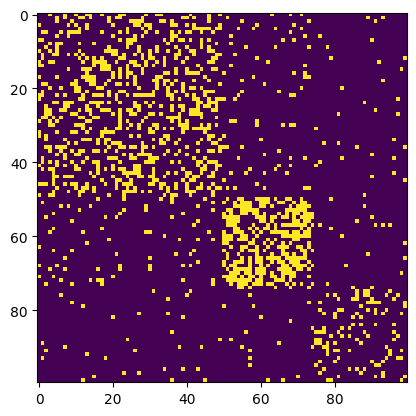

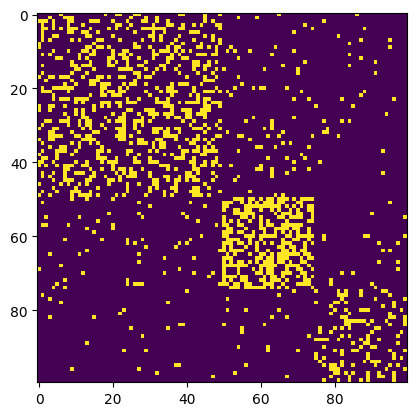

In [15]:
def generate_sbm(sizes, probs):

    assert probs.shape == (len(sizes), len(sizes))

    G = nx.stochastic_block_model(sizes, probs)
    E = nx.to_numpy_array(G)
    gammas = np.zeros((sum(sizes), len(sizes)))

    for i, size in enumerate(sizes):
        gammas[int(np.sum(sizes[:i])):int(np.sum(sizes[:i+1])), i] = 1.0

    return E, gammas

B  = np.array([[0.3, 0.05, 0.02],
              [0.05, 0.5, 0.03],
              [0.02, 0.03, 0.2]])
E, gammas = generate_sbm([50,25,25], B)


plt.imshow(E)
plt.show()

#print(gammas)
    
model = LNMMSB(100, 3, key=42, B=B, gamma_tilde=jnp.array(gammas))
E = model.generate_graph()
plt.imshow(E)
plt.show()




In [19]:
import time
start = time.time()
model_jit = jit_LNMMSB(nodes=100, roles=3, key=43)
model.fit(E, verbose=False, max_inner_iters=1000, max_outer_iters=1000)
end = time.time()
total_jit = end - start
print(f"JIT time {total_jit // 60}m {total_jit % 60:.4f} seconds")

start = time.time()
model = LNMMSB(nodes=100, roles=3, key=43)
model.fit(E, verbose=False, max_inner_iters=1000, max_outer_iters=1000)
end = time.time()
total_non_jit = end - start
print(f"Non-JIT time {total_non_jit // 60}m {total_non_jit % 60:.4f} seconds")

print(f"Acceleration factor {(total_non_jit / total_jit):.2f}x")



JIT time 0.0m 1.5709 seconds
Non-JIT time 0.0m 13.6180 seconds
Acceleration factor 8.67x


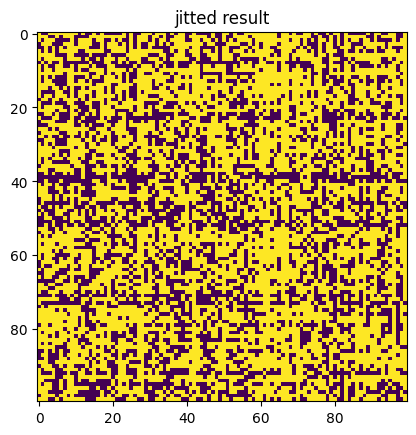

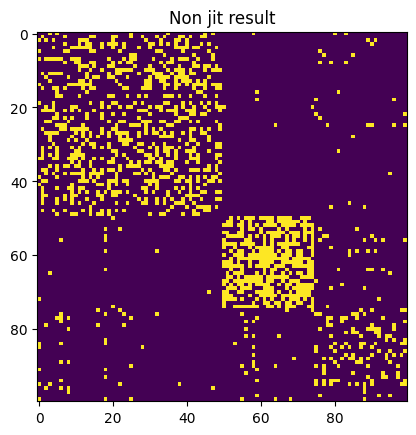

Same result: False


In [20]:

E_sampled_jit = model_jit.generate_graph()
plt.figure()    
plt.title("jitted result")
plt.imshow(E_sampled_jit)
plt.show()

E_sampled = model.generate_graph()
plt.figure()    
plt.title("Non jit result")
plt.imshow(E_sampled)
plt.show()

print("Same result:", jnp.array_equal(E_sampled, E_sampled_jit))

In [ ]:
jnp.set_printoptions(precision=4)
print(f"Learned B:\n {model.B}")
print("True B:\n", B)

Learned B:
 [[1.     1.     1.    ]
 [1.     0.1438 1.    ]
 [1.     1.     1.    ]]
True B:
 [[0.3  0.05 0.02]
 [0.05 0.5  0.03]
 [0.02 0.03 0.2 ]]


#### Sanity check

In [ ]:
import numpy as np
gamma_tilde = jnp.arange(16).reshape(4,4).astype(jnp.float32)

print("gamma tilde:", gamma_tilde)
gamma_i = gamma_tilde[:, None, :, None]
gamma_j = gamma_tilde[None, :, None, :]


gamma_sum = gamma_i + gamma_j

print(gamma_sum.shape)
# print(gamma_sum)

N = 4
K = 4
delta = np.zeros((4, 4, 4, 4))
gamma_means = gamma_tilde

for i in range(N):
    for j in range(N):
        for u in range(K):
            for v in range(K):
                delta[i, j, u, v] = gamma_means[i, u] + gamma_means[j, v]

print(jnp.all(delta == gamma_sum))

        

gamma tilde: [[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]
(4, 4, 4, 4)
True


In [ ]:
def f(**kwargs):
    print(kwargs['gamma'] == None)

f(hello = 1)

KeyError: 'gamma'